<a href="https://colab.research.google.com/github/Nato9-7/EDA_FundamentosML_RenatoDiaz/blob/main/InformeML_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd # Pandas es una biblioteca de análisis y manipulación de datos.
import numpy as np # Numpy es una biblioteca para el cálculo numérico en Python.
import matplotlib.pyplot as plt # Matplotlib es una biblioteca para la creación de gráficos en Python.
from scipy.stats import norm # La distribución normal es una distribución de probabilidad continua que se utiliza ampliamente en estadística.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pickle

In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
cs_df = pd.read_csv(name, sep=",", encoding='UTF-8')

Saving DF_CS_ARREGLADO.csv to DF_CS_ARREGLADO.csv


count    666.000000
mean      79.792793
std       22.072178
min        6.000000
25%       66.000000
50%       78.000000
75%       94.000000
max      136.000000
Name: RoundKills, dtype: float64


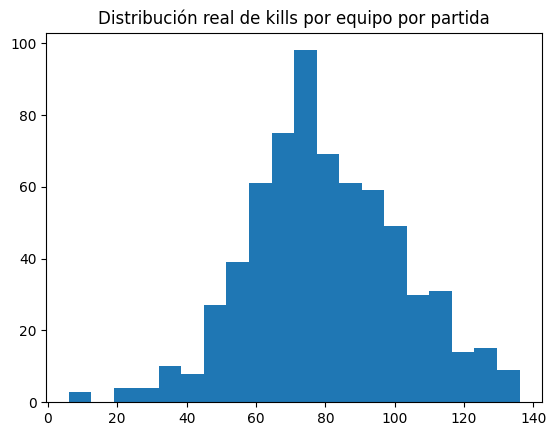

In [3]:
datos = cs_df.groupby(['MatchId', 'Team']).agg({
    'RoundKills': 'sum',
    'TeamStartingEquipmentValue': 'mean',
    'PrimarySniperRifle': 'mean',
    'RLethalGrenadesThrown': 'sum',
    'RNonLethalGrenadesThrown': 'sum',
    "PrimaryHeavy" : "mean",
    "PrimarySMG" : "mean",
    "PrimaryPistol" : "mean"
}).reset_index()
# Verificar distribución
print(datos['RoundKills'].describe())
plt.hist(datos['RoundKills'], bins=20)
plt.title('Distribución real de kills por equipo por partida')
plt.show()

#RANDOM FOREST

In [4]:
X = datos.drop(['MatchId', 'Team', 'RoundKills'], axis=1)
y = datos['RoundKills']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Modelamiento

In [6]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

In [7]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1,            # Usa todos los núcleos disponibles
    scoring='neg_mean_squared_error',
    verbose=1
)

In [8]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

##Observación

In [9]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)  # Datos de entrenamiento
y_test_pred = best_model.predict(X_test)    # Datos de prueba

# Evaluación
y_test_pred = best_model.predict(X_test)
print(f"R²\t\t{r2_score(y_train, y_train_pred):.3f}\t\t{r2_score(y_test, y_test_pred):.3f}\t\t{round(r2_score(y_train, y_train_pred) - r2_score(y_test, y_test_pred), 3)}")
print(f"MAE\t\t{mean_absolute_error(y_train, y_train_pred):.2f}\t\t{mean_absolute_error(y_test, y_test_pred):.2f}\t\t{round(mean_absolute_error(y_train, y_train_pred) - mean_absolute_error(y_test, y_test_pred), 2)}")


Mejores parámetros encontrados:
{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
R²		0.916		0.747		0.169
MAE		5.04		9.40		-4.37


Este modelo nos dio un 74% del r2 y un desvio de kills +-9 kills. También se observa un overfitting

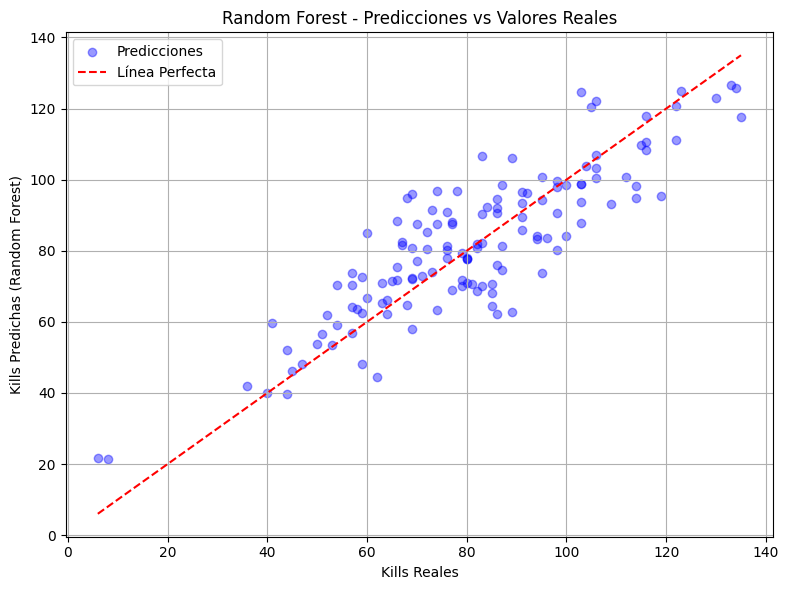

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4, color='blue', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Línea Perfecta')
plt.xlabel('Kills Reales')
plt.ylabel('Kills Predichas (Random Forest)')
plt.title('Random Forest - Predicciones vs Valores Reales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()